In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("dataset.csv")
# Проверим данные
df.info() # Пропусков нет
df.describe() # Выбросов нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 3000 non-null   object
 1   AGE                    3000 non-null   int64 
 2   SMOKING                3000 non-null   int64 
 3   YELLOW_FINGERS         3000 non-null   int64 
 4   ANXIETY                3000 non-null   int64 
 5   PEER_PRESSURE          3000 non-null   int64 
 6   CHRONIC_DISEASE        3000 non-null   int64 
 7   FATIGUE                3000 non-null   int64 
 8   ALLERGY                3000 non-null   int64 
 9   WHEEZING               3000 non-null   int64 
 10  ALCOHOL_CONSUMING      3000 non-null   int64 
 11  COUGHING               3000 non-null   int64 
 12  SHORTNESS_OF_BREATH    3000 non-null   int64 
 13  SWALLOWING_DIFFICULTY  3000 non-null   int64 
 14  CHEST_PAIN             3000 non-null   int64 
 15  LUNG_CANCER          

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,55.169000,1.491000,1.514000,1.494000,1.499000,1.509667,1.489667,1.506667,1.497333,1.491333,1.510667,1.488000,1.489667,1.498667
std,14.723746,0.500002,0.499887,0.500047,0.500082,0.499990,0.499977,0.500039,0.500076,0.500008,0.499970,0.499939,0.499977,0.500082
min,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,55.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,68.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,80.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [9]:
# Разбиение на возрастные категории по риску
def age(_age):
  if _age < 20:
    return 0
  elif 20 >= _age < 40:
    return 1
  elif 40 >= _age < 60:
    return 2
  else:
    return 3
df['AGE'] = df['AGE'].apply(age)

In [10]:
# Кодируем категориальные данные
df['GENDER'] = df['GENDER'].map({'M':0, 'F':1})
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'NO':0, 'YES':1})
df['LUNG_CANCER'].describe()

count    3000.000000
mean        0.506000
std         0.500047
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: LUNG_CANCER, dtype: float64

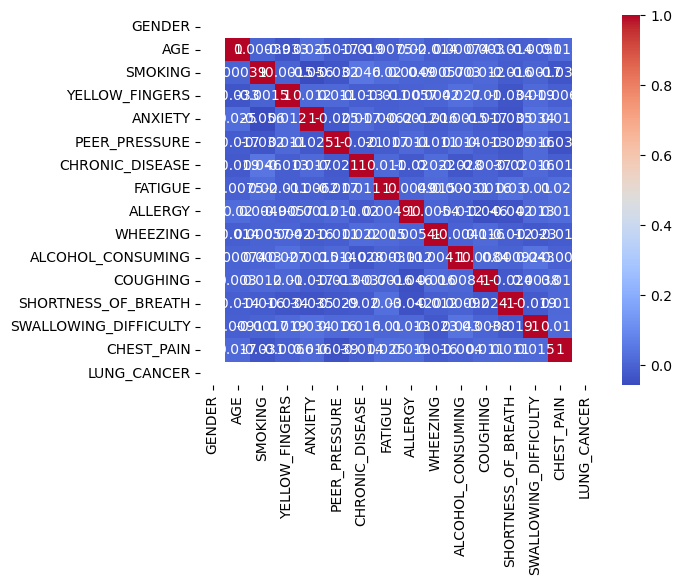

In [7]:
# Проверяем на отсутствие зависимых данных
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show() # Корреляций нет

In [6]:
# Разделяем данные на обучающую и тестовую выборки
X = df.drop(columns=['LUNG_CANCER'])  # Признаки (features)
y = df['LUNG_CANCER']  # Целевая переменная (target)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# Создаём объект KFold для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)
hyperscore={}
# здесь будет цикл для перебора гиперпараметров
for i in tqdm(range(10, 210, 10)):
    for j in range(6):
        if j==0:
            j = None
        for k in range(2, 6):
            
            # Кросс-валидация
            score_lst=[]
            for train_index, val_index in kf.split(X):
                
                scaler = StandardScaler()
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                # Применение стандартизации к числовым признакам (сначала обучаем скейлер на обучающих данных)
                X_train_scaled = scaler.fit_transform(X_train)
                # Применение обученного скейлера к тестовой выборке
                X_val_scaled = scaler.transform(X_val)
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                # Обучение и тестирование модели происходит внутри этого цикла
                clf = RandomForestClassifier(n_estimators=i, max_depth=j, min_samples_split=k, random_state=123)
                clf.fit(X_train_scaled, y_train)
                y_pred = clf.predict(X_val)
                
                # Используем метрику F-beta score
                score = fbeta_score(y_val, y_pred, beta=3)
                prec = precision_score(y_val, y_pred)
                rec = recall_score(y_val, y_pred)
                score_lst.append((score, prec, rec))
            hyperscore[(i,j,k)] = tuple(map(np.mean, zip(*score_lst)))

 30%|██████████████████████████████▌                                                                       | 6/20 [10:21<24:10, 103.60s/it]


KeyboardInterrupt: 

In [5]:
_list = list(map(lambda _c: _c[0], filter(lambda _b: _b[1]==np.float64(0.6718195129144074), sorted(hyperscore.items(), key= lambda _a: -_a[1]))))
_list

NameError: name 'hyperscore' is not defined

In [ ]:
_hyperscore = dict()
for i, j, k in tqdm(_list):
    #Кросс-валидация
    score_lst=[]
    for train_index, val_index in kf.split(X):
        
        scaler = StandardScaler()
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        # Применение стандартизации к числовым признакам (сначала обучаем скейлер на обучающих данных)
        X_train_scaled = scaler.fit_transform(X_train)
        # Применение обученного скейлера к тестовой выборке
        X_val_scaled = scaler.transform(X_val)
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Обучение и тестирование модели происходит внутри этого цикла
        clf = RandomForestClassifier(n_estimators=i, max_depth=j, min_samples_split=k, random_state=123)
        for _ in range(100):
            clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val)
        
        # Используем метрику F-beta score
        score = fbeta_score(y_val, y_pred, beta=3)
        score_lst.append(score)
    _hyperscore[(i,j,k)] = np.mean(score_lst)
print(_hyperscore)